In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
TRAIN_DIR = "horse-or-human-dataset/train"
VAL_DIR = "horse-or-human-dataset/validation"

training_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size = (150, 150),
    batch_size = 32,
    label_mode = "binary"
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size = (150,150),
    batch_size = 32,
    label_mode = "binary"
)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [3]:
training_dataset_final = (training_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE))
validation_dataset_final = (validation_dataset.cache().prefetch(tf.data.AUTOTUNE))

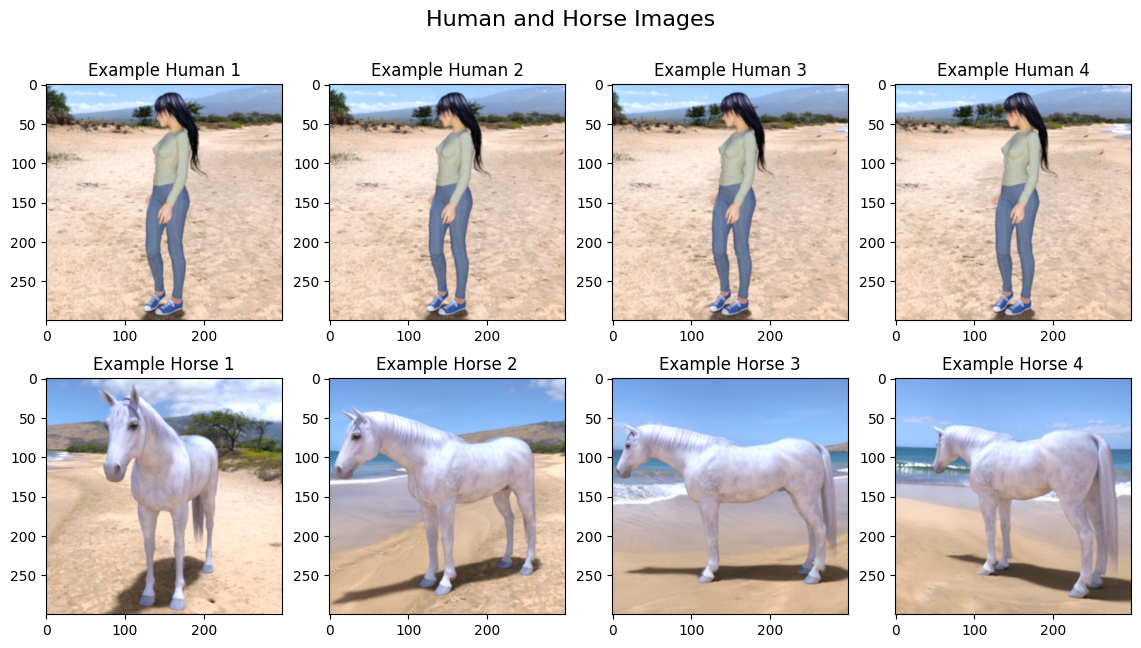

In [4]:
HUMANS_DIR = f"{TRAIN_DIR}/humans"
HORSES_DIR = f"{TRAIN_DIR}/horses"

humans_filenames = os.listdir(HUMANS_DIR)
horses_filenames = os.listdir(HORSES_DIR)

humans_images = [f"{HUMANS_DIR}/{filename}" for filename in humans_filenames]
horses_images = [f"{HORSES_DIR}/{filename}" for filename in horses_filenames]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Human and Horse Images', fontsize=16)

# Plot the first 4 images of each class
for i, human_image in enumerate(humans_images[:4]):
    img = tf.keras.utils.load_img(human_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Human {i+1}')

for i, horse_image in enumerate(horses_images[:4]):
    img = tf.keras.utils.load_img(horse_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Horse {i+1}')
plt.show()


In [5]:
class EarlyStopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs["accuracy"] >= 0.995 and logs["val_accuracy"] >= 0.85:
            self.model.stop_training = True
            print("\nStopped!")

In [6]:
data_augmentation_layers = Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    RandomFlip("horizontal"),
    RandomRotation(0.2, fill_mode="nearest"),
    RandomTranslation(0.2, 0.2, fill_mode="nearest"),
    RandomZoom(0.2, fill_mode="nearest")
], name="augmentation_layers")

In [7]:
model = Sequential(
    [
        tf.keras.Input(shape=(150, 150, 3)),
        data_augmentation_layers,
        Rescaling(1./255),
        Conv2D(16, (3,3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3,3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(1, activation="sigmoid")
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layers             │ (None, 150, 150, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,391,329 (9.12 MB)

 Trainable params: 2,391,329 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    loss = BinaryCrossentropy,
    optimizer = Adam(0.0001),
    metrics = ["accuracy"]
)

In [ ]:
history = model.fit(
    training_dataset_final,
    epochs = 20,
    validation_data = validation_dataset_final,
    callbacks = [EarlyStopCallback()]
)

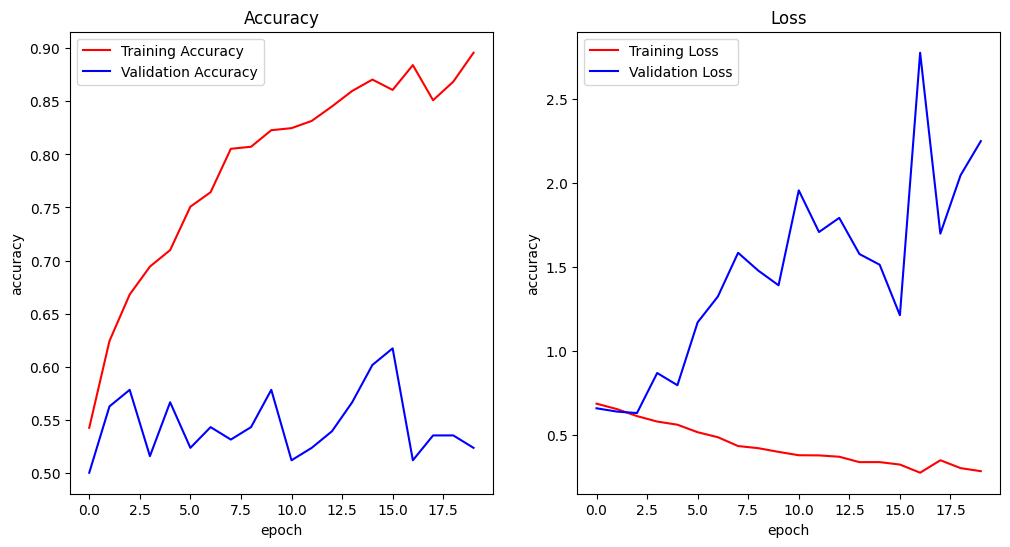

In [10]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(epochs, acc, "r", label="Training Accuracy")
ax[0].plot(epochs, val_acc, "b", label="Validation Accuracy")
ax[0].legend()
ax[0].set_title("Accuracy")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("accuracy")

ax[1].plot(epochs, loss, "r", label="Training Loss")
ax[1].plot(epochs, val_loss, "b", label="Validation Loss")
ax[1].legend()
ax[1].set_title("Loss")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
plt.show()

### ---Still Overfitting--